![](http://i67.tinypic.com/2jcbwcw.png)

## Data-X: EDA of Ocean Trash Level

Plastic Pollution in the World’s Oceans: More than 5 Trillion Plastic Pieces Weighing over 250,000 Tons Afloat at Sea

This is a map of the field locations where count density was measured between 2007-2013 using surface manta tows. Count density (pieces km22; see colors in legend) of marine plastic debris for various plastic size class (0.33-1.00, 1.01-4.75, 4.76-200, and over 200 mm).
In the following EDA we only examine the trash data from 2012.
The underlying research paper can be found here: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0111913

## Import packages

In [1]:
# No warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

pd.set_option('display.max_columns', 100) # Print 100 Pandas columns

import matplotlib.pyplot as plt
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier #stochastic gradient descent
from sklearn.tree import DecisionTreeClassifier

### Define fancy plot to look at distributions

In [3]:
# Special distribution plot (will be used later)
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    plt.tight_layout()

## Input Data

In [4]:
data = pd.read_excel('PlasticMarinePollutionGlobalDataset.xlsx')

# Exploratory Data Anlysis (EDA)
We will analyze the data to see how we can work with it and what makes sense.

In [5]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 16 columns):
Date            1571 non-null object
Latitude        1571 non-null float64
Longitude       1571 non-null float64
CD1  (/km^2)    680 non-null object
CD2  (/km^2)    680 non-null object
CD3  (/km^2)    808 non-null object
CD4  (/km^2)    1090 non-null object
WD1 (g/km^2)    442 non-null object
WD2 (g/km^2)    442 non-null object
WD3 (g/km^2)    570 non-null object
WD4 (g/km^2)    888 non-null object
Sea State       1214 non-null object
Source          1571 non-null object
Info            1571 non-null object
Comments        37 non-null object
Unnamed: 15     377 non-null object
dtypes: float64(2), object(14)
memory usage: 196.6+ KB


,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Sea State,Source,Info,Comments,Unnamed: 15
0,NaN,NaN,NaN,.335-.999 mm,1.00-4.75 mm,4.75-200 mm,>200 mm,.335-.999 mm,1.00-4.75 mm,4.75-200 mm,>200 mm,(Beaufort Scale),NaN,NaN,NaN,NaN
1,2010-09-01 00:00:00,19.9432,-64.5649,58103,21259.9,2226.17,NaN,4.45,26.83,4.23,NaN,2.5,M. Eriksen,NAG10-SM001,NaN,NaN
2,2010-09-01 00:00:00,20.2173,-64.3828,6639.79,4031.3,1067.11,NaN,1.04,28.69,40.79,NaN,2,M. Eriksen,NAG10-SM002,NaN,NaN
3,2010-09-01 00:00:00,20.4521,-64.1968,15246.7,12147.8,991.66,NaN,2.57,42.62,3503.27,NaN,2,M. Eriksen,NAG10-SM003,NaN,NaN
4,2010-10-01 00:00:00,21.1293,-63.8333,5347.35,6851.29,1420.39,NaN,1.15,12.86,4.26,NaN,2,M. Eriksen,NAG10-SM004,NaN,NaN


In [6]:
print(data.columns.values)

['Date' 'Latitude' 'Longitude' 'CD1  (/km^2)' 'CD2  (/km^2)'
 'CD3  (/km^2)' 'CD4  (/km^2)' 'WD1 (g/km^2)' 'WD2 (g/km^2)'
 'WD3 (g/km^2)' 'WD4 (g/km^2)' 'Sea State' 'Source' 'Info' 'Comments'
 'Unnamed: 15']


In [7]:
print('Number of NaNs in the dataframe:\n',data.isnull().sum())

Number of NaNs in the dataframe:
 Date               1
Latitude           1
Longitude          1
CD1  (/km^2)     892
CD2  (/km^2)     892
CD3  (/km^2)     764
CD4  (/km^2)     482
WD1 (g/km^2)    1130
WD2 (g/km^2)    1130
WD3 (g/km^2)    1002
WD4 (g/km^2)     684
Sea State        358
Source             1
Info               1
Comments        1535
Unnamed: 15     1195
dtype: int64


In [8]:
#Drop unwanted columns and transform date column
data_d = data.iloc[1:].drop(columns=['Sea State','Source', 'Info','Comments','Unnamed: 15'])
data_d['Date'] = pd.to_datetime(data_d['Date'])
data_d.head()

,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2)
1,2010-09-01,19.9432,-64.5649,58103,21259.9,2226.17,NaN,4.45,26.83,4.23,NaN
2,2010-09-01,20.2173,-64.3828,6639.79,4031.3,1067.11,NaN,1.04,28.69,40.79,NaN
3,2010-09-01,20.4521,-64.1968,15246.7,12147.8,991.66,NaN,2.57,42.62,3503.27,NaN
4,2010-10-01,21.1293,-63.8333,5347.35,6851.29,1420.39,NaN,1.15,12.86,4.26,NaN
5,2010-10-01,21.4730,-63.5899,4090.58,5317.76,409.06,NaN,0.48,29.63,4.36,NaN


In [9]:
data_by_year = data_d #.set_index('Date')
data_by_year.head()

,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2)
1,2010-09-01,19.9432,-64.5649,58103,21259.9,2226.17,NaN,4.45,26.83,4.23,NaN
2,2010-09-01,20.2173,-64.3828,6639.79,4031.3,1067.11,NaN,1.04,28.69,40.79,NaN
3,2010-09-01,20.4521,-64.1968,15246.7,12147.8,991.66,NaN,2.57,42.62,3503.27,NaN
4,2010-10-01,21.1293,-63.8333,5347.35,6851.29,1420.39,NaN,1.15,12.86,4.26,NaN
5,2010-10-01,21.4730,-63.5899,4090.58,5317.76,409.06,NaN,0.48,29.63,4.36,NaN


In [10]:
#group data by years
data_by_year['Date'] = pd.to_datetime(data_by_year['Date'])
data_by_year['Year'] = data_by_year['Date'].dt.year

In [11]:
#number of datapoints per year
df_by_year = data_by_year.groupby('Year')
df_by_year['Year'].count()

Year
2007     25
2008    410
2009    110
2010    223
2011    242
2012    394
2013    167
Name: Year, dtype: int64

In [12]:
data_by_year_nn = data_by_year.fillna(0,axis=0).loc[data_by_year['Longitude'].between(-179, -114)].loc[data_by_year['Latitude'].between(14, 53)].drop(['Date'], axis=1)
data_by_year_nn['Total Accumulation'] = data_by_year_nn['WD1 (g/km^2)'] + data_by_year_nn['WD2 (g/km^2)'] + data_by_year_nn['WD3 (g/km^2)'] + data_by_year_nn['WD4 (g/km^2)']
data_by_year_nn['Total Count'] = data_by_year_nn[data_by_year_nn.columns[3:6]].sum(axis=1)
data_by_year_nn.head()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
140,37.2045,-133.8650,15506.45,18552.36,1107.60,0.0,2.90,36.88,61.06,0.0,2007,100.84,19659.96
141,37.1755,-133.9495,32472.93,68218.32,14348.50,0.0,8.84,297.77,1158.28,0.0,2007,1464.89,82566.82
142,38.1515,-137.4531,118621.69,97000.01,14282.21,0.0,13.69,88.07,3654.46,0.0,2007,3756.22,111282.22
143,38.6913,-141.7720,17257.50,18881.74,2436.35,0.0,1.89,35.90,37.76,0.0,2007,75.55,21318.09
144,38.6878,-142.0264,5100.93,14353.77,1660.77,0.0,1.87,22.04,224.67,0.0,2007,248.58,16014.54


In [13]:
data_by_year_nn = data_by_year.fillna(0,axis=0).loc[data_by_year['Longitude'].between(-179, -114)].loc[data_by_year['Latitude'].between(14, 53)]
data_by_year_nn['Total Accumulation'] = data_by_year_nn['WD1 (g/km^2)'] + data_by_year_nn['WD2 (g/km^2)'] + data_by_year_nn['WD3 (g/km^2)'] + data_by_year_nn['WD4 (g/km^2)']
data_by_year_nn['Total Count'] = data_by_year_nn[data_by_year_nn.columns[3:6]].sum(axis=1)
data_by_year_nn.head()

,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
140,2007-09-16,37.2045,-133.8650,15506.45,18552.36,1107.60,0.0,2.90,36.88,61.06,0.0,2007,100.84,35166.41
141,2007-09-16,37.1755,-133.9495,32472.93,68218.32,14348.50,0.0,8.84,297.77,1158.28,0.0,2007,1464.89,115039.75
142,2007-09-18,38.1515,-137.4531,118621.69,97000.01,14282.21,0.0,13.69,88.07,3654.46,0.0,2007,3756.22,229903.91
143,2007-09-20,38.6913,-141.7720,17257.50,18881.74,2436.35,0.0,1.89,35.90,37.76,0.0,2007,75.55,38575.59
144,2007-09-20,38.6878,-142.0264,5100.93,14353.77,1660.77,0.0,1.87,22.04,224.67,0.0,2007,248.58,21115.47


In [14]:
data_by_year_nn.describe()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,33.088021,-152.202177,17143.567781,25402.584726,2797.544491,26.214047,3.300574,143.319008,564.914830,8924.807206,2009.924282,9636.341619,45343.696997
std,5.119997,10.755887,52065.062582,63358.232210,7550.979763,74.510166,10.417206,584.790116,2087.127709,27629.538230,1.458684,27496.254850,112496.915381
min,18.158700,-178.907200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2007.000000,0.000000,0.000000
25%,30.867500,-157.743900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000,133.485000,0.000000
50%,34.050000,-153.264500,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,113.340000,2010.000000,1250.110000,0.000000
75%,36.233350,-144.830800,6877.895000,17490.935000,1568.950000,18.290000,1.530000,46.830000,49.360000,5665.235000,2011.000000,7192.880000,31743.440000
max,46.650000,-119.800000,478350.990000,391763.530000,65028.350000,693.960000,100.410000,9278.230000,21516.300000,308741.060000,2012.000000,308741.060000,762220.890000


In [15]:
dataset = data_by_year_nn[['Date','Latitude', 'Longitude', 'Total Accumulation']].sort_values(by=['Total Accumulation'])
dataset.loc[dataset['Total Accumulation'] > 0, 'Total Accumulation'] = 1
dataset.to_csv('2007-2013.csv', index=False)

In [16]:
bins = [0, 133, 1250, 7000, 10000]
dataset['Total Accumulation'] = pd.cut(dataset['Total Accumulation'], bins,labels=[0,1,2,3])

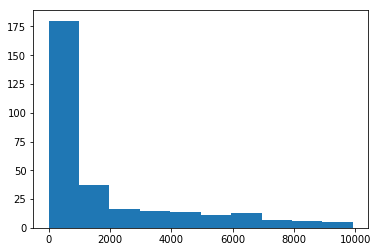

In [17]:
#result['Total Accumulation'] = result['Total Accumulation'] < 10000
data_by_year_nn = data_by_year_nn[data_by_year_nn['Total Accumulation']<=10000]
data_by_year_nn.head()
plt.hist(data_by_year_nn["Total Accumulation"], 10);
#result.loc[result['Total Count'] > 0, 'Total Count'] = 1

In [18]:
data_by_year_nn.describe()

,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,32.816145,-152.082522,20403.281217,28884.356414,3281.760066,6.508882,3.875197,166.809737,443.164770,1181.894309,2009.690789,1795.744013,52569.397697
std,5.519077,11.057409,56976.482619,65280.766222,8146.947234,13.755666,11.314850,645.411912,1293.151391,2203.504759,1.417633,2467.293191,119427.007992
min,18.158700,-178.907200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2007.000000,0.000000,0.000000
25%,30.385300,-158.128675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2009.000000,50.152500,0.000000
50%,33.926650,-154.318400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2010.000000,607.755000,0.000000
75%,36.264800,-143.651225,13795.917500,24281.760000,2459.295000,7.062500,2.077500,90.802500,127.960000,1222.547500,2011.000000,2540.835000,43963.447500
max,46.650000,-119.800000,478350.990000,389901.840000,65028.350000,110.610000,100.410000,9278.230000,8302.320000,9781.710000,2012.000000,9921.660000,762220.890000


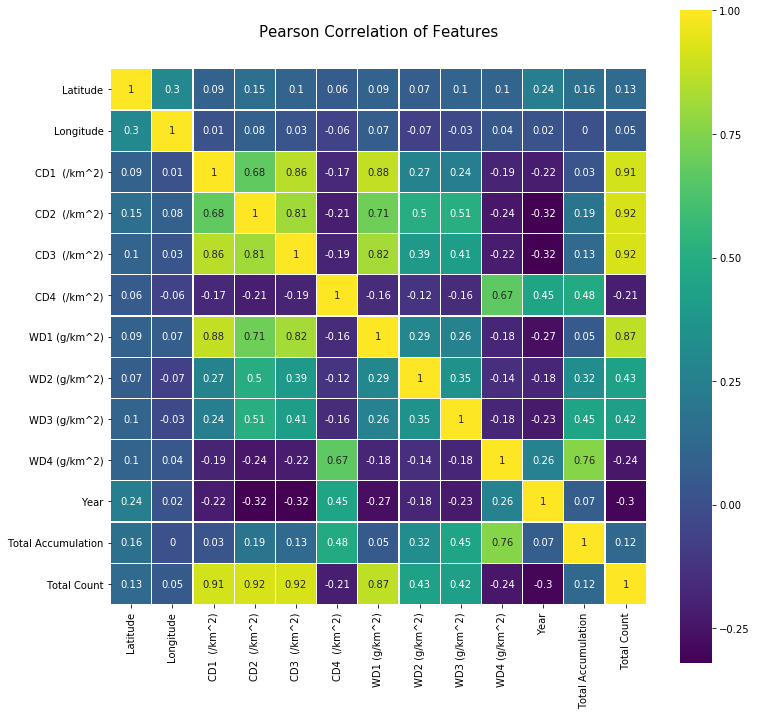

In [19]:
import seaborn as sns
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_by_year_nn.corr().round(2)\
            ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
            linecolor='white', annot=True);

In [20]:
df_2007 = data_by_year_nn[data_by_year_nn['Year']==[2007]]
df_2007.head()

,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
140,2007-09-16,37.2045,-133.8650,15506.45,18552.36,1107.60,0.0,2.90,36.88,61.06,0.0,2007,100.84,35166.41
141,2007-09-16,37.1755,-133.9495,32472.93,68218.32,14348.50,0.0,8.84,297.77,1158.28,0.0,2007,1464.89,115039.75
142,2007-09-18,38.1515,-137.4531,118621.69,97000.01,14282.21,0.0,13.69,88.07,3654.46,0.0,2007,3756.22,229903.91
143,2007-09-20,38.6913,-141.7720,17257.50,18881.74,2436.35,0.0,1.89,35.90,37.76,0.0,2007,75.55,38575.59
144,2007-09-20,38.6878,-142.0264,5100.93,14353.77,1660.77,0.0,1.87,22.04,224.67,0.0,2007,248.58,21115.47


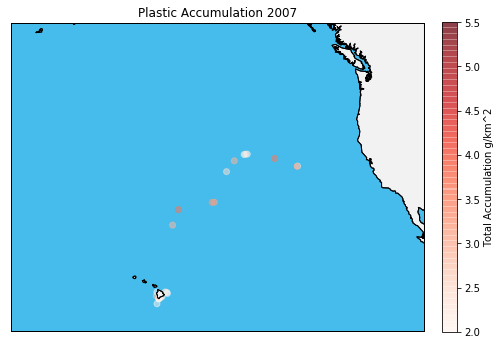

In [21]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = df_2007['Latitude'].values
lon = df_2007['Longitude'].values
accum1 = df_2007['WD1 (g/km^2)'].values
accum2 = df_2007['WD2 (g/km^2)'].values
accum3 = df_2007['WD3 (g/km^2)'].values
accum4 = df_2007['WD4 (g/km^2)'].values
accumulation = df_2007['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2007', fontdict=None, loc='center', pad=None);

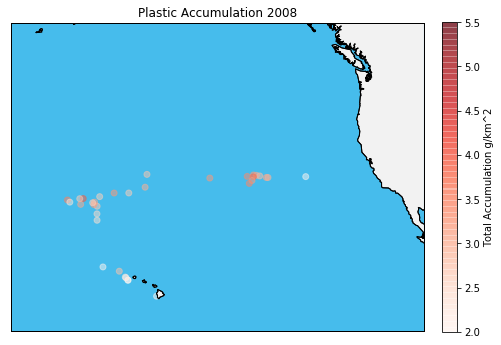

In [22]:
df_2008 = data_by_year_nn[data_by_year_nn['Year']==[2008]]
df_2008.head()
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = df_2008['Latitude'].values
lon = df_2008['Longitude'].values
accum1 = df_2008['WD1 (g/km^2)'].values
accum2 = df_2008['WD2 (g/km^2)'].values
accum3 = df_2008['WD3 (g/km^2)'].values
accum4 = df_2008['WD4 (g/km^2)'].values
accumulation = df_2008['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2008', fontdict=None, loc='center', pad=None);

In [23]:
df_2009 = data_by_year_nn[data_by_year_nn['Year']==[2009]]
df_2009.head()

,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
202,2009-06-15,25.1070,-128.1097,14058.05,12993.04,3834.01,0.0,3.07,7.22,32.38,0.0,2009,42.67,30885.10
203,2009-06-15,24.2205,-128.3530,2491.81,4600.27,766.71,0.0,0.35,4.60,0.77,0.0,2009,5.72,7858.79
204,2009-06-16,23.5677,-130.3722,4561.04,7367.83,2105.09,0.0,0.67,7.30,9.44,0.0,2009,17.41,14033.96
205,2009-06-21,24.6048,-146.3870,1045.21,1254.26,209.04,0.0,0.22,4.92,23.31,0.0,2009,28.45,2508.51
206,2009-06-21,24.5445,-146.4777,1983.31,1873.13,330.55,0.0,0.24,2.66,114.26,0.0,2009,117.16,4186.99


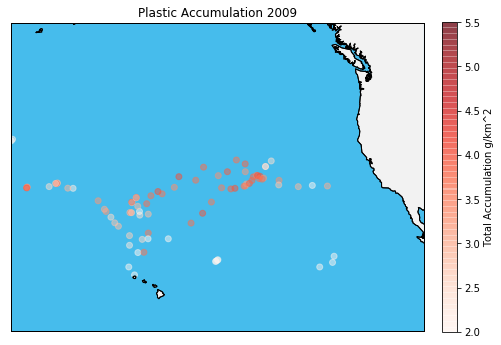

In [24]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = df_2009['Latitude'].values
lon = df_2009['Longitude'].values
accum1 = df_2009['WD1 (g/km^2)'].values
accum2 = df_2009['WD2 (g/km^2)'].values
accum3 = df_2009['WD3 (g/km^2)'].values
accum4 = df_2009['WD4 (g/km^2)'].values
accumulation = df_2009['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2009', fontdict=None, loc='center', pad=None);

In [25]:
df_2010 = data_by_year_nn[data_by_year_nn['Year']==[2010]]
df_2010.head()

,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
226,2010-12-07,34.4452,-176.4782,44996.4,78743.7,937.43,0.00,10.22,89.06,15.0,0.00,2010,114.28,124677.53
534,2010-02-08,31.6442,-158.0152,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,2010,0.00,0.00
535,2010-03-08,33.1199,-158.1481,0.0,0.0,0.00,1.37,0.00,0.00,0.0,68.60,2010,68.60,0.00
536,2010-03-08,33.6833,-158.0500,0.0,0.0,0.00,6.97,0.00,0.00,0.0,1216.62,2010,1216.62,0.00
537,2010-03-08,34.0500,-157.9833,0.0,0.0,0.00,1.26,0.00,0.00,0.0,2581.77,2010,2581.77,0.00


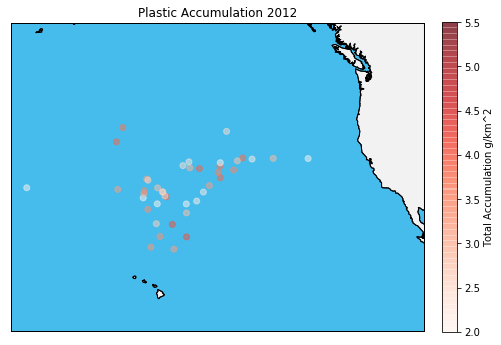

In [26]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = df_2010['Latitude'].values
lon = df_2010['Longitude'].values
accum1 = df_2010['WD1 (g/km^2)'].values
accum2 = df_2010['WD2 (g/km^2)'].values
accum3 = df_2010['WD3 (g/km^2)'].values
accum4 = df_2010['WD4 (g/km^2)'].values
accumulation = df_2010['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2012', fontdict=None, loc='center', pad=None);

In [27]:
df_2011 = data_by_year_nn[data_by_year_nn['Year']==[2011]]
df_2011.head()

,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
270,2011-11-07,31.5383,-156.8608,6798.71,24281.09,5827.46,0.0,0.87,0.29,903.26,0.0,2011,904.42,36907.26
271,2011-11-07,32.2027,-156.8332,6957.08,21280.47,5320.12,0.0,1.19,162.55,308.57,0.0,2011,472.31,33557.67
272,2011-07-14,39.1247,-156.9162,4548.72,24397.70,2894.64,0.0,1.98,74.60,6083.67,0.0,2011,6160.25,31841.06
273,2011-07-14,40.2005,-156.7070,13470.24,29695.75,2755.28,0.0,1.07,109.38,84.92,0.0,2011,195.37,45921.27
274,2011-07-15,41.0398,-156.2367,16016.88,66276.76,3313.84,0.0,2.71,265.05,38.66,0.0,2011,306.42,85607.48


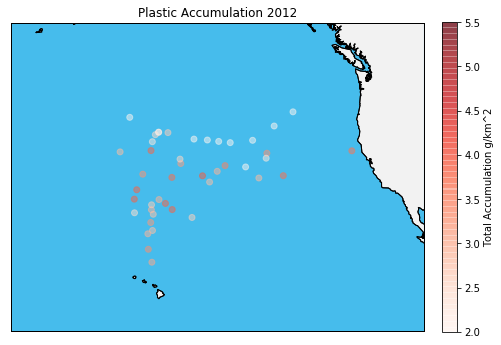

In [28]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = df_2011['Latitude'].values
lon = df_2011['Longitude'].values
accum1 = df_2011['WD1 (g/km^2)'].values
accum2 = df_2011['WD2 (g/km^2)'].values
accum3 = df_2011['WD3 (g/km^2)'].values
accum4 = df_2011['WD4 (g/km^2)'].values
accumulation = df_2011['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2012', fontdict=None, loc='center', pad=None);

In [29]:
df_2012 = data_by_year_nn[data_by_year_nn['Year']==[2012]]
df_2012.head()

,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
177,2012-01-29,33.0118,-167.9233,30557.56,45116.39,3519.72,0.00,5.12,202.86,1014.32,0.00,2012,1222.30,79193.67
318,2012-06-26,30.2817,-176.8333,14421.28,17457.33,759.01,0.00,0.87,51.35,31.88,0.00,2012,84.10,32637.62
319,2012-06-27,31.1333,-174.3002,13779.54,22259.26,1766.61,0.00,0.67,146.45,1837.98,0.00,2012,1985.10,37805.41
483,2012-06-26,30.3412,-175.5211,0.00,0.00,0.00,19.87,0.00,0.00,0.00,1291.78,2012,1291.78,0.00
485,2012-06-27,31.1517,-174.0432,0.00,0.00,0.00,48.95,0.00,0.00,0.00,3051.81,2012,3051.81,0.00


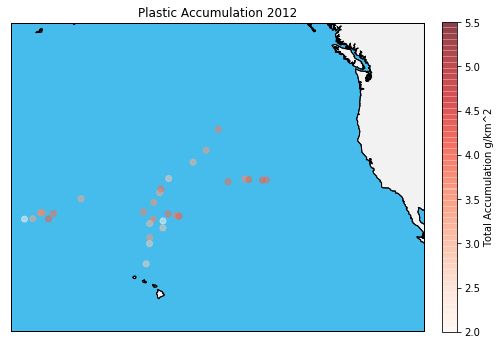

In [30]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

#trash data
lat = df_2012['Latitude'].values
lon = df_2012['Longitude'].values
accum1 = df_2012['WD1 (g/km^2)'].values
accum2 = df_2012['WD2 (g/km^2)'].values
accum3 = df_2012['WD3 (g/km^2)'].values
accum4 = df_2012['WD4 (g/km^2)'].values
accumulation = df_2012['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon, lat, latlon=True,
          c=np.log10(accumulation),
          cmap='Reds', alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2012', fontdict=None, loc='center', pad=None);

In [31]:
df_2013 = data_by_year_nn[data_by_year_nn['Year']==[2012]]
df_2013.head()

,Date,Latitude,Longitude,CD1 (/km^2),CD2 (/km^2),CD3 (/km^2),CD4 (/km^2),WD1 (g/km^2),WD2 (g/km^2),WD3 (g/km^2),WD4 (g/km^2),Year,Total Accumulation,Total Count
177,2012-01-29,33.0118,-167.9233,30557.56,45116.39,3519.72,0.00,5.12,202.86,1014.32,0.00,2012,1222.30,79193.67
318,2012-06-26,30.2817,-176.8333,14421.28,17457.33,759.01,0.00,0.87,51.35,31.88,0.00,2012,84.10,32637.62
319,2012-06-27,31.1333,-174.3002,13779.54,22259.26,1766.61,0.00,0.67,146.45,1837.98,0.00,2012,1985.10,37805.41
483,2012-06-26,30.3412,-175.5211,0.00,0.00,0.00,19.87,0.00,0.00,0.00,1291.78,2012,1291.78,0.00
485,2012-06-27,31.1517,-174.0432,0.00,0.00,0.00,48.95,0.00,0.00,0.00,3051.81,2012,3051.81,0.00


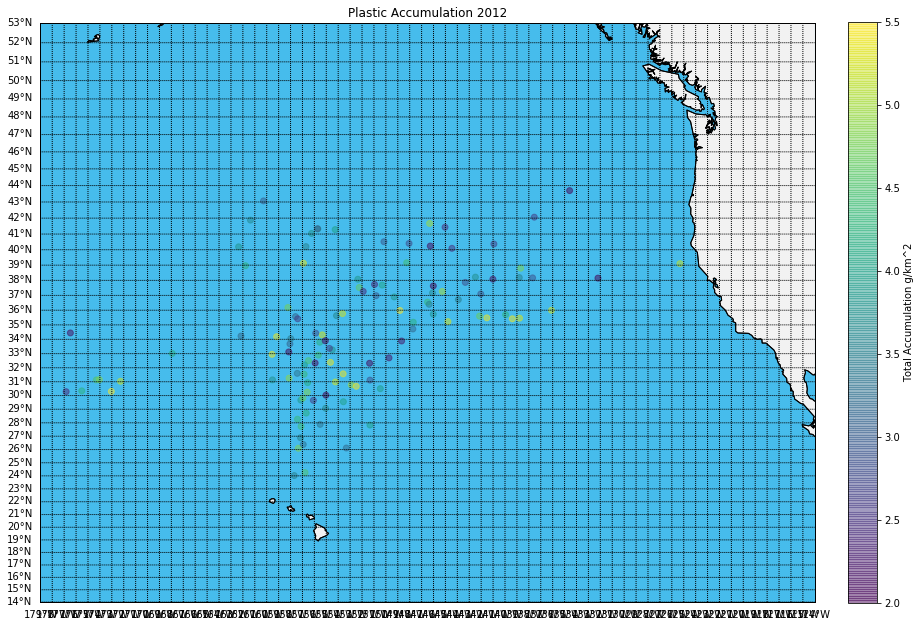

In [32]:
fig, ax = plt.subplots(figsize=(15,18))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,1.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,180.,1.),labels=[0,0,0,1]);

#trash data
lat1 = df_2013['Latitude'].values
lon1 = df_2013['Longitude'].values
accumulation1 = df_2013['Total Accumulation'].values
lat2 = df_2011['Latitude'].values
lon2 = df_2011['Longitude'].values
accumulation2 = df_2011['Total Accumulation'].values
lat3 = df_2010['Latitude'].values
lon3 = df_2010['Longitude'].values
accumulation3 = df_2010['Total Accumulation'].values
#count = pacific['Total Count'].values

#scatter plot trash data
m.scatter(lon1, lat1, latlon=True,
          c=np.log10(accumulation1), alpha=0.5);
m.scatter(lon2, lat2, latlon=True,
          c=np.log10(accumulation2), alpha=0.5);
m.scatter(lon3, lat3, latlon=True,
          c=np.log10(accumulation3), alpha=0.5);

# m.scatter(lon, lat, latlon=True,
#           c=np.log10(accumulation), s=count/100,
#           cmap='Reds', alpha=0.5);

#colorbar and legend
plt.colorbar(fraction=0.0347, pad=0.04,label=r'Total Accumulation g/km^2')
plt.clim(2, 5.5)
matplotlib.pyplot.title('Plastic Accumulation 2012', fontdict=None, loc='center', pad=None);

In [33]:
#trash data
lat13 = df_2013['Latitude'].values
lon13 = df_2013['Longitude'].values
accumulation13 = df_2013['Total Accumulation'].values
#count = pacific['Total Count'].values

#trash data
lat11= df_2011['Latitude'].values
lon11 = df_2011['Longitude'].values
accumulation12 = df_2011['Total Accumulation'].values
#count = pacific['Total Count'].values

#trash data
lat07= df_2007['Latitude'].values
lon07 = df_2007['Longitude'].values
accumulation07 = df_2007['Total Accumulation'].values
#count = pacific['Total Count'].values

#trash data
lat08= df_2008['Latitude'].values
lon08 = df_2008['Longitude'].values
accumulation08 = df_2008['Total Accumulation'].values
#count = pacific['Total Count'].values

#trash data
lat09= df_2009['Latitude'].values
lon09 = df_2009['Longitude'].values
accumulation09 = df_2009['Total Accumulation'].values
#count = pacific['Total Count'].values

#trash data
lat10= df_2010['Latitude'].values
lon10 = df_2010['Longitude'].values
accumulation10 = df_2010['Total Accumulation'].values
#count = pacific['Total Count'].values

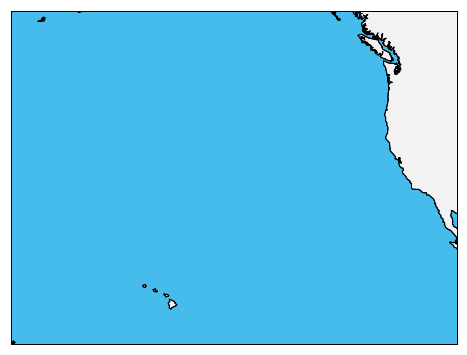

In [34]:
fig, ax = plt.subplots(figsize=(8,12))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=33.5, lon_0=-146.5,
            llcrnrlon=-179, llcrnrlat=14 , urcrnrlon=-114, urcrnrlat=53)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines();

m.scatter(lat11,lon11, c='b', marker='x', label='1')
m.scatter(lat13, lon13, c='r', marker='x', label='-1')
m.scatter(lat07, lon07, c='g', marker='x', label='-1')
m.scatter(lat08, lon08, c='y', marker='x', label='-1')
m.scatter(lat09, lon09, c='orange', marker='x', label='-1')
m.scatter(lat10, lon10, c='black', marker='x', label='-1');

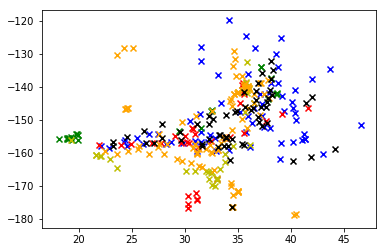

In [35]:
import matplotlib.pyplot as plt

plt.scatter(lat11,lon11, c='b', marker='x', label='1')
plt.scatter(lat13, lon13, c='r', marker='x', label='-1')
plt.scatter(lat07, lon07, c='g', marker='x', label='-1')
plt.scatter(lat08, lon08, c='y', marker='x', label='-1')
plt.scatter(lat09, lon09, c='orange', marker='x', label='-1')
plt.scatter(lat10, lon10, c='black', marker='x', label='-1');